In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pathlib import Path
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import albumentations as A

tf.__version__

'2.4.1'

In [4]:
PATH = '/kaggle/input/'

os.listdir(PATH)

['dataset-melanoma224', 'melanoma224']

In [5]:
train = pd.read_csv(f'{PATH}/melanoma224/train.csv')
#val = pd.read_csv(f'{PATH}/dataset-melanoma224/val_split.csv')
train = train.fillna("unk") # sustituimos los valores na por unk
train.shape


(33126, 8)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     33126 non-null  object
 1   patient_id                     33126 non-null  object
 2   sex                            33126 non-null  object
 3   age_approx                     33126 non-null  object
 4   anatom_site_general_challenge  33126 non-null  object
 5   diagnosis                      33126 non-null  object
 6   benign_malignant               33126 non-null  object
 7   target                         33126 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.0+ MB


In [7]:
train['age_approx'] = train['age_approx'].astype(str)

In [8]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder()
cols = ["sex","age_approx","anatom_site_general_challenge"]
oh_encoder.fit(train[cols])
oh_encoder.categories_

[array(['female', 'male', 'unk'], dtype=object),
 array(['0.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0',
        '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0',
        '85.0', '90.0', 'unk'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unk', 'upper extremity'], dtype=object)]

In [9]:
oh_encoder.transform([["female","0.0","head/neck"]]).toarray() # la matrix sparse representa una matrix en onehotencoding respecto a los valores insertados

array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [10]:
# una vez entrenado nuesto onehotencoder podremos cargar los datasets con los que entrenaremos nuestra red neuronal
train = pd.read_csv(f'{PATH}/dataset-melanoma224/subset.csv')
val = pd.read_csv(f'{PATH}/dataset-melanoma224/val_split.csv')
train = train.fillna("unk")
val = val.fillna("unk")
train['age_approx'] = train['age_approx'].astype(str)
val['age_approx'] = val['age_approx'].astype(str)

In [11]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE # Permite obtener el numero de cpu 


def decode(name, meta, label):
    img = tf.io.read_file(name)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.cast(img, tf.float32)
    return img,meta, label

def augment(img, meta, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return (img, meta), label # A la red neuronal siempre le tenemos que dar dos datos inputs y labels, es por ello que deberemos meter tanto la img y meta en una tupla
    # example (img, meta, ...), (label, ...)
def load_ds(df):
    options = tf.data.Options()
    options.experimental_deterministic = False
    #---------------
    imgs , labels = df["image_name"].values, df["target"].values
    imgs = [f'{PATH}/melanoma224/jpeg224/train/{name}.jpg' for name in imgs]
    meta = df[cols]
    meta = oh_encoder.transform(meta).toarray()# Aplicamos el onehotencoder
    ds = tf.data.Dataset.from_tensor_slices((imgs, meta, labels))
    ds = ds.with_options(options) # Aplicamos las opciones que hemos puesto
    ds = ds.map(decode, num_parallel_calls=AUTO)
    ds = ds.cache()
    ds = ds.map(augment, num_parallel_calls=AUTO)
    ds = ds.shuffle(2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTO) # Mientras la gpu esta calculando la cpu vaya leyendo imagenes
    return ds


In [12]:
train_ds = load_ds(train)
val_ds = load_ds(val)

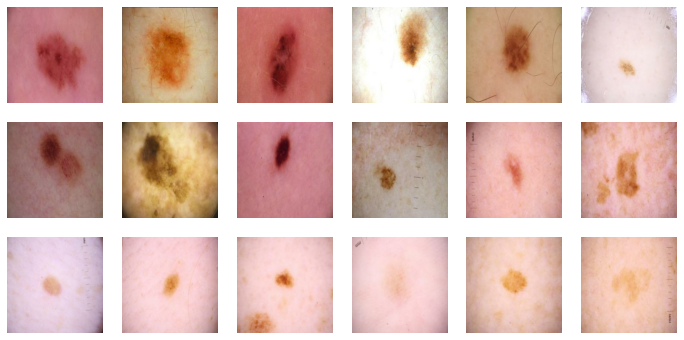

In [13]:
r, c = 3,6
fig = plt.figure(figsize=(2*c,2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r,c, _r*c + _c + 1)
        for data, labels in train_ds.take(1):
            imgs, meta = data
            img = imgs[0].numpy()/255 #El decode hemos puesto que nuestro datos sean float y da problea si es el numero entre 0-255 float por eso hay que pasarlo a int 
            plt.imshow(img)
            plt.axis(False)
plt.show()

In [14]:
for data, labels in train_ds.take(1):
    imgs, meta = data
    print(meta)

tf.Tensor(
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]], shape=(64, 29), dtype=float64)


In [15]:
IMAGE_SIZE = (224,224,3)

encoder = ResNet50V2(
    include_top=False,
    input_shape=IMAGE_SIZE,
    weights='imagenet'
)
encoder.trainable=False

# Cuando tenemos varios inputs en keras hay que ponerle diferentes nombres a cada inputs

imgs = keras.Input(shape=IMAGE_SIZE, name="image")
#x = keras.layers.experimental.preprocessing.RandomFlip()(inputs)# Aplicamos las transformaciones directamente en la capa neuronal. Las transformaciones las hara la gpu en vez de la cpu
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(imgs)
x = encoder(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)

metadata = keras.Input(shape=(29,), name="metadata")
y = keras.layers.Dense(100,activation="relu")(metadata)
y = keras.layers.Dense(3,activation="relu")(y)

# Concatenamos los datos de las imagenes y de los metadatos
z = keras.layers.concatenate([x,y])

outputs = keras.layers.Dense(1, activation="sigmoid")(z)

model = keras.Model(inputs=[imgs, metadata], outputs=outputs)
model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
metadata (InputLayer)           [(None, 29)]         0                                            
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 7, 7, 2048)   23564800    rescaling[0][0]                  
______________________________________________________________________________________________

In [16]:
#Compilamos el modelo
model.compile(
optimizer=keras.optimizers.Adam(),
loss=keras.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name="auc")]
)

In [17]:

# Creamos nuestra callbacks
filepath = f"kaggle/working/checkpoints/checkpoint"
cb = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath,
monitor="val_auc",
verbose=1,
save_best_only=True,
save_weights_only=True, # Guardar todo el modelo o solo los pesos
mode="max", # Guardara el valor maximo del parametro que monitorizamos, en caso de loss poner "min"
)

In [18]:
#Entrenamos nuestro modelo
model.fit(train_ds,
      epochs=10,
      validation_data=val_ds,
      validation_steps=10,
      callbacks=[cb])

Epoch 1/10
35/35 [==============================] - 21s 398ms/step - loss: 0.3700 - auc: 0.3732 - val_loss: 0.1426 - val_auc: 0.4153

Epoch 00001: val_auc improved from -inf to 0.41525, saving model to kaggle/working/checkpoints/checkpoint
Epoch 2/10
35/35 [==============================] - 7s 202ms/step - loss: 0.0981 - auc: 0.3331 - val_loss: 0.1002 - val_auc: 0.4329

Epoch 00002: val_auc improved from 0.41525 to 0.43294, saving model to kaggle/working/checkpoints/checkpoint
Epoch 3/10
35/35 [==============================] - 7s 193ms/step - loss: 0.0866 - auc: 0.5660 - val_loss: 0.0923 - val_auc: 0.6610

Epoch 00003: val_auc improved from 0.43294 to 0.66096, saving model to kaggle/working/checkpoints/checkpoint
Epoch 4/10
35/35 [==============================] - 8s 210ms/step - loss: 0.0938 - auc: 0.6568 - val_loss: 0.1023 - val_auc: 0.5510

Epoch 00004: val_auc did not improve from 0.66096
Epoch 5/10
35/35 [==============================] - 7s 203ms/step - loss: 0.0685 - auc: 0.725

In [19]:
# Al final de cada for cargamos los mejores pesos
model.load_weights(filepath)
model.save(f"/kaggle/working/model1.h5")# Deberemos indicar nombres diferentes para guardar los diferentes modelos que generemos

In [20]:
# Cargamos las metricas
auc = model.evaluate(val_ds) # Evaluate nos devolverá la "loss" y la metrica "auc" 
    

171/171 [==============================] - 34s 188ms/step - loss: 0.0768 - auc: 0.7974


In [21]:
auc

[0.07683545351028442, 0.7973846793174744]

In [22]:
test = pd.read_csv(f'{PATH}/melanoma224/test.csv')
test = test.fillna("unk")
test["age_approx"] = test["age_approx"].astype(str)

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     10982 non-null  object
 1   patient_id                     10982 non-null  object
 2   sex                            10982 non-null  object
 3   age_approx                     10982 non-null  object
 4   anatom_site_general_challenge  10982 non-null  object
dtypes: object(5)
memory usage: 429.1+ KB


In [24]:
BATCH_SIZE = 64

def decode_test(name, meta):
    img = tf.io.read_file(name)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.cast(img, tf.float32)
    return {"image":img, "metadata":meta}


def load_test_ds(df):
    imgs  = df["image_name"].values
    imgs = [f'{PATH}/melanoma224/jpeg224/test/{name}.jpg' for name in imgs]
    meta = df[cols]
    meta = oh_encoder.transform(meta).toarray()# Aplicamos el onehotencoder
    ds = tf.data.Dataset.from_tensor_slices((imgs,meta))
    ds = ds.map(decode_test, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE)
    return ds

In [25]:
test_ds = load_test_ds(test)


In [26]:
preds = model.predict(test_ds)

In [29]:
test

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,unk
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso
10978,ISIC_9996992,IP_4890115,male,35.0,torso
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity


In [30]:
submission = pd.DataFrame({
    'image_name':test['image_name'].values,
    'target':preds.ravel()
})

In [31]:
submission.to_csv("/kaggle/working/submission.csv", index=False)
